In [1]:
options(warn = -1)
library('stringr')
library('hunspell')
library('ds4psy')
library('glue')
library('spacyr')
library('tm')
library('dplyr',  warn.conflicts = FALSE)
library('parsedate')
library("tokenizers", warn.conflicts = FALSE)

# replacing contractions with full forms
library('textclean')
library('caret')
library("e1071")

# initializing spacyr
spacy_initialize(model = 'en_core_web_sm', virtualenv  = "/Users/yobahbertrandyonkou/spacyenv/")

# importing model
msa_model = readRDS("../Models/msa_model_81_lyrics_and_sentiments_only.rda")

# loading corpus
angry_corpus = readRDS("../Model testing/angry_corpus.rda")
sad_corpus = readRDS("../Model testing/sad_corpus.rda")
happy_corpus = readRDS("../Model testing/happy_corpus.rda")

Welcome to ds4psy (v0.9.0)!

Loading required package: NLP

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:NLP’:

    annotate


Loading required package: lattice

successfully initialized (spaCy Version: 3.4.3, language model: en_core_web_sm)

(python options: type = "virtualenv", value = "/Users/yobahbertrandyonkou/spacyenv/")



In [84]:
classify_lyrics = function(test_lyrics){
    # replacing ’ with '
    lyrics = str_replace_all(test_lyrics, "’", "\'")

    # converting lyrics to lower case
    lyrics = tolower(lyrics)

    # removing lyrics divisions
    lyrics = str_replace_all(
            string=lyrics, 
            pattern=r"(\[(.*?)\])", 
            replacement = " "
        )

    # typo correction
    bad.words = hunspell(lyrics)

    # splitting bad words to a list of words
    bad.words = text_to_words(bad.words[1])

    # removing duplicates
    bad.words = unique(bad.words)

    # getting suggestions
    suggested.words = unlist(lapply(hunspell_suggest(unique(unlist(bad.words))), function(words) words[1]))

    # replacing bad words with suggestions
    new_lyrics = ""
    for (index in 1:length(bad.words)){
        new_lyrics = str_replace_all(
            string = lyrics, 
            pattern = glue(r"(\b{bad.words[index]}\b)"), 
            replacement = suggested.words[index]
        )
        lyrics = new_lyrics
    }
    lyrics = tolower(lyrics)

    # replacing all contractions with their full forms
    lyrics = replace_contraction(lyrics)

    lyrics = replace_internet_slang(lyrics)
    lyrics = str_replace_all(lyrics, r"(\_?\-)", " ")
    lyrics = str_replace_all(lyrics, r"(\d)", " ")
    lyrics = str_replace_all(
            string=lyrics, 
            pattern=r"(\s+)", 
            replacement = " "
        )

    # pos tagging, lematization
    # Not using transform here because it combines every thing into one long string
    important = c()
    lemmatized_lyrics = c()
    features = filter(
        spacy_parse(lyrics, tag=TRUE, pos=TRUE), 
        !(pos %in% important) & (entity == "")
    )

    lemmatized_lyrics = append(
        lemmatized_lyrics, 
        paste(features$lemma, collapse = ' ')
    )
    lyrics = lemmatized_lyrics

    # fetching english stopwords
    stopwords.list = stopwords(kind = "en")

    # removing contractions from stop words because lyrics does not have stop words
    stopwords.cleaned = tolower(replace_contraction(stopwords.list))

    for (stopword in stopwords.cleaned){
        lyrics = str_remove_all(tolower(lyrics), glue(r"(\b\s?{stopword}\b)"))
    }

    lyrics = tolower(removePunctuation(lyrics))

    lyrics = str_replace_all(
            string=lyrics, 
            pattern=r"(\s+)", 
            replacement = " "
        )

    lyrics_corpus = Corpus(VectorSource(lyrics))

    # creating a document term matrix from lyrics corpus
    get_lyrics_document_term_matrix = function(lyrics_corpus){
        return (
            removeSparseTerms(
                DocumentTermMatrix(lyrics_corpus, control = list(
                    weighting=function(x) weightTfIdf(x, normalize = TRUE)
                )), 0.95
            )
        )
    }

    lyric_with_angry_corpus = Corpus(VectorSource(c(lyrics_corpus$content, angry_corpus$content)))
    dtm_with_angry = get_lyrics_document_term_matrix(lyric_with_angry_corpus)
    lyric_with_happy_corpus = Corpus(VectorSource(c(lyrics_corpus$content, happy_corpus$content)))
    dtm_with_happy = get_lyrics_document_term_matrix(lyric_with_happy_corpus)
    lyric_with_sad_corpus = Corpus(VectorSource(c(lyrics_corpus$content, sad_corpus$content)))
    dtm_with_sad = get_lyrics_document_term_matrix(lyric_with_sad_corpus)

    # converting dtm to matrix
    get_lyrics_dtm_matrix = function(lyrics_document_term_matrix) as.matrix(lyrics_document_term_matrix[1 , ])

    with_happy = get_lyrics_dtm_matrix(dtm_with_happy)
    with_sad = get_lyrics_dtm_matrix(dtm_with_sad)
    with_angry = get_lyrics_dtm_matrix(dtm_with_angry)

    # predictions
    pred_for_happy = predict(msa_model, data.frame(with_happy), type = "raw")
    pred_for_angry = predict(msa_model, data.frame(with_angry), type = "raw")
    pred_for_sad = predict(msa_model, data.frame(with_sad), type = "raw")

    result = array(pred_for_angry + pred_for_happy + pred_for_sad)
    labels = array(names(data.frame(pred_for_angry + pred_for_happy + pred_for_sad)))
    max = 1
    index = 1
    for (value in pred_for_happy + pred_for_sad + pred_for_angry){
        if(value > result[max]){
            max = index
        }
        index = index + 1
    }
#     print(probs)
    return (labels[max])
}

In [99]:
# loading data sets
d_and_d = read.csv("./tintin_toronto.csv")

In [100]:
# classification
results = c()
for(lyrics in d_and_d$lyrics){
    results = append(results, classify_lyrics(lyrics))
}

In [104]:
length(d_and_d$lyrics)
length(results)

[1] 34

[1] 34

In [105]:
d_and_d['sentiments'] = results

In [106]:
write.csv(d_and_d, "tintin_toronto_with_sentiment.csv")

In [107]:
d_and_d = read.csv("./d_and_d_with_sentiment.csv")

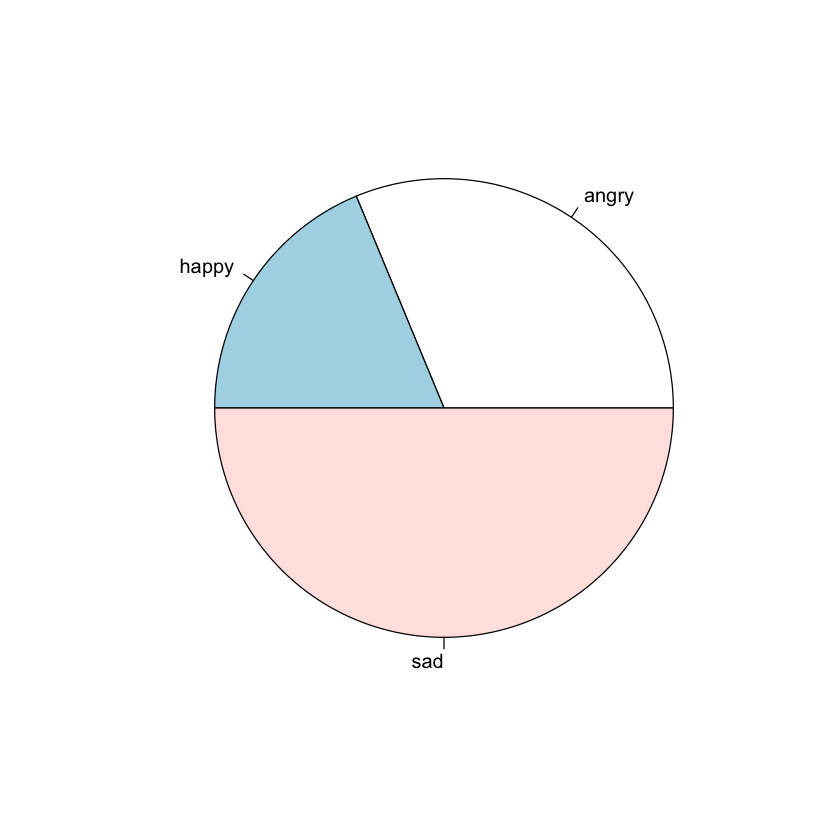

In [110]:
pie(table(d_and_d$sentiments))

In [129]:
library(fmsb)

[DATA NOT ENOUGH] at 3
NA
 [DATA NOT ENOUGH] at 3
NA
 [DATA NOT ENOUGH] at 3
NA
[DATA NOT ENOUGH] at 2
NA
 [DATA NOT ENOUGH] at 2
NA
 [DATA NOT ENOUGH] at 2
NA


ERROR: Error in polygon(xxs, yys, lty = pltys[i - 2], lwd = plwds[i - 2], border = pcols[i - : invalid value specified for graphical parameter "lwd"


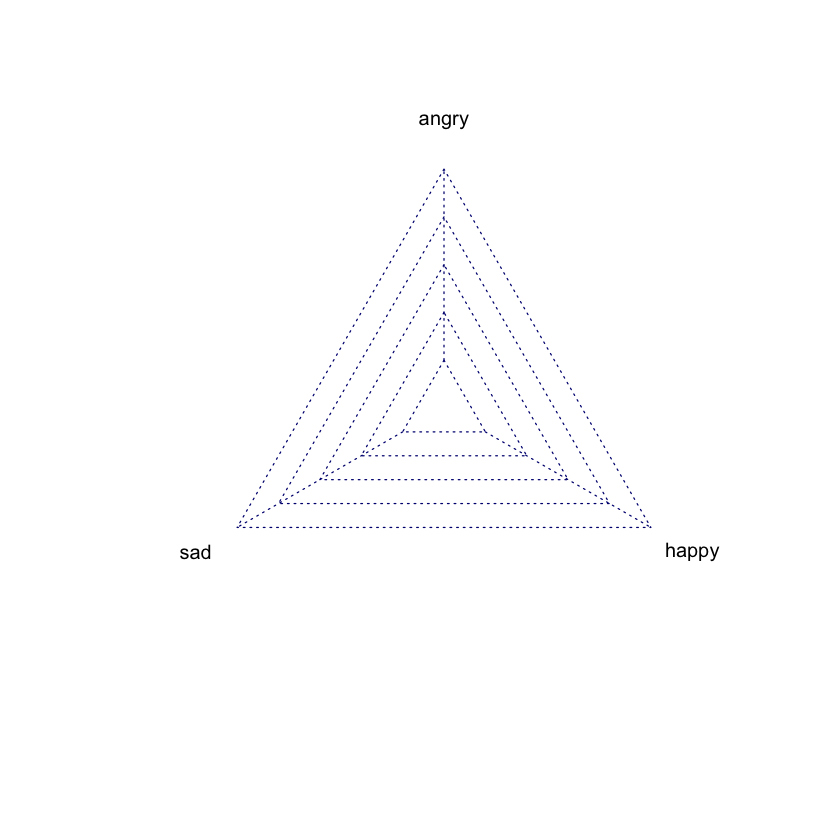

In [121]:
data

In [122]:
set.seed(99)
data <- as.data.frame(matrix( sample( 0:20 , 15 , replace=F) , ncol=5))
data

V1,V2,V3,V4,V5
<int>,<int>,<int>,<int>,<int>
15,2,1,3,8
0,9,5,18,14
11,13,12,10,20


In [124]:
colnames(data) <- c("math" , "english" , "biology" , "music" , "R-coding" )
data

math,english,biology,music,R-coding
<int>,<int>,<int>,<int>,<int>
15,2,1,3,8
0,9,5,18,14
11,13,12,10,20


In [125]:
rownames(data) <- paste("mister" , letters[1:3] , sep="-")

In [126]:
data

,math,english,biology,music,R-coding
,<int>,<int>,<int>,<int>,<int>
mister-a,15,2,1,3,8
mister-b,0,9,5,18,14
mister-c,11,13,12,10,20


In [127]:
data <- rbind(rep(20,5) , rep(0,5) , data)
data

,math,english,biology,music,R-coding
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20,20,20,20,20
2,0,0,0,0,0
mister-a,15,2,1,3,8
mister-b,0,9,5,18,14
mister-c,11,13,12,10,20


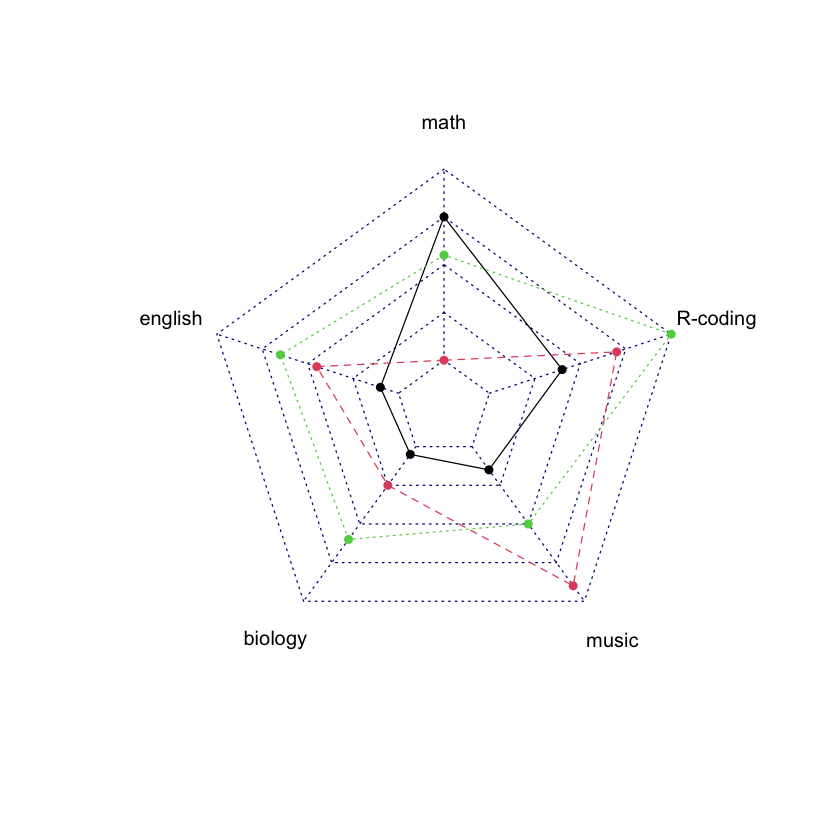

In [130]:
radarchart(data)

In [152]:
temp = data.frame(table(d_and_d$sentiments))

In [153]:
temp

Var1,Freq
<fct>,<int>
angry,10
happy,6
sad,16


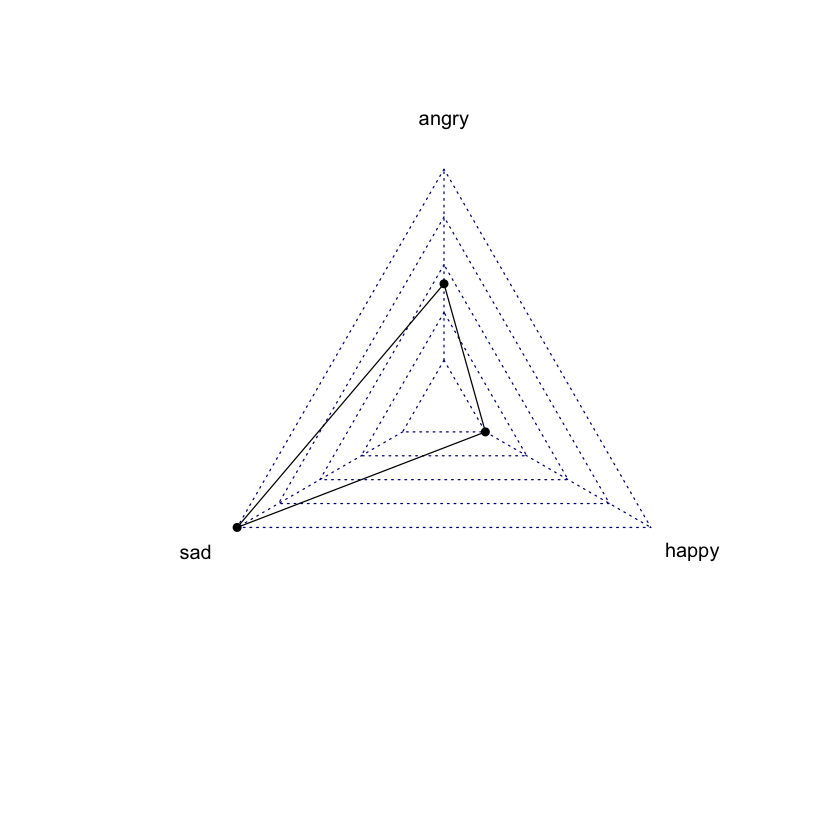

In [160]:
data = data.frame(
    angry=c(max(temp$Freq), min(temp$Freq), 10),
    sad=c(max(temp$Freq), min(temp$Freq), 16),
    happy=c(max(temp$Freq), min(temp$Freq), 6)
)
radarchart(data)

   Var1 Freq
1 angry   10
2 happy    6
3   sad   16


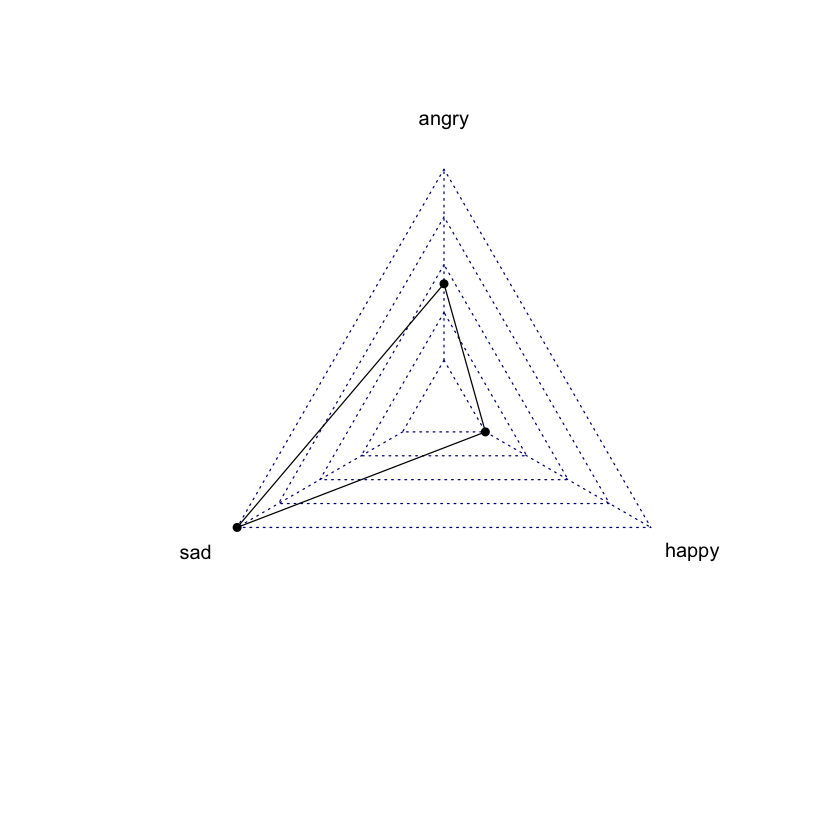

In [169]:
d_and_d = read.csv("./d_and_d_with_sentiment.csv")
temp = data.frame(table(d_and_d$sentiments))
print(temp)
data = data.frame(
    angry=c(max(temp$Freq), min(temp$Freq), 10),
    sad=c(max(temp$Freq), min(temp$Freq), 16),
    happy=c(max(temp$Freq), min(temp$Freq), 6)
)
radarchart(data)

   Var1 Freq
1 angry   21
2 happy    2
3   sad   11


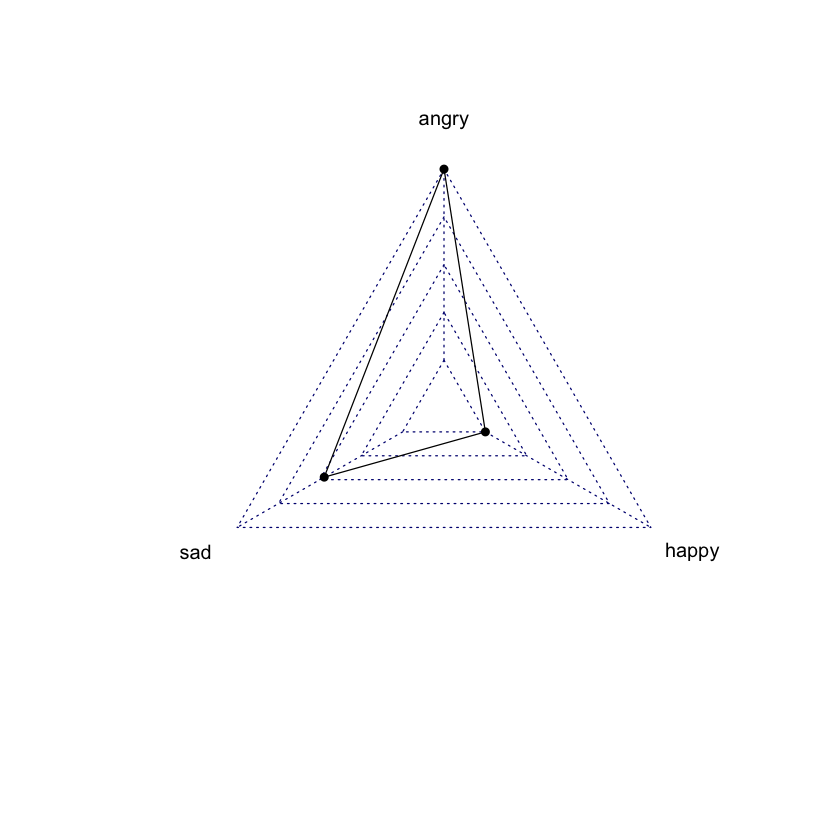

In [171]:
spotify_caffine = read.csv("./spotify_caffine_with_sentiment.csv")
temp = data.frame(table(spotify_caffine$sentiments))
print(temp)
data = data.frame(
    angry=c(max(temp$Freq), min(temp$Freq), 21),
    sad=c(max(temp$Freq), min(temp$Freq), 11),
    happy=c(max(temp$Freq), min(temp$Freq), 2)
)
radarchart(data)

   Var1 Freq
1 angry    9
2 happy    8
3   sad   17


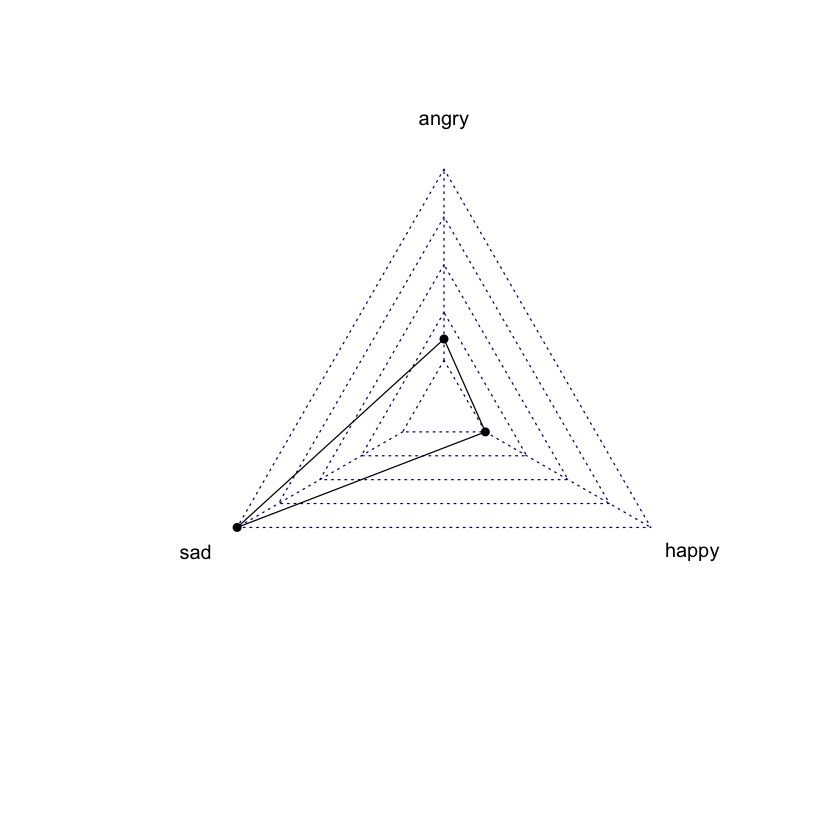

In [174]:
tintin_toronto = read.csv("./tintin_toronto_with_sentiment.csv")
temp = data.frame(table(tintin_toronto$sentiments))
print(temp)
data = data.frame(
    angry=c(max(temp$Freq), min(temp$Freq), 9),
    sad=c(max(temp$Freq), min(temp$Freq), 17),
    happy=c(max(temp$Freq), min(temp$Freq), 8)
)
radarchart(data)